In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print('Setup done')

Setup done


In [2]:
# from google.colab import drive

# drive.mount('/content/gdrive',force_remount=True)

### Reading csv

In [2]:
df = pd.read_csv('./dataset/dataset_brazil.csv')
df['Date']= pd.to_datetime(df['Date'])

df_client_rfm = pd.read_csv('./dataset/client_rfm.csv', sep=',')

print("dataset Loaded")

dataset Loaded


In [3]:
df_client_rfm = df_client_rfm[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']]

In [4]:
df_client_product = df[['Client','ProductId','Rating']].copy()
df_client_product = pd.merge(df_client_product,df_client_rfm,on='Client',how='left')

df_client_product.drop_duplicates(keep='first',inplace=True,subset=['Client','ProductId']) 


n_users = df_client_product['Client'].nunique()
n_users

10816

In [5]:
df_product = df[['ProductId','Product','Product Category','Product Cost']].copy()
df_product.drop_duplicates(keep='first',inplace=True) 

n_prod = df_product['ProductId'].nunique()
n_prod

54708

#### Enocding prod-ID

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

prod_enc = LabelEncoder()
df_client_product['Client'] = prod_enc.fit_transform(df_client_product['Client'].values)

# prod_enc = LabelEncoder()
# df_product['Product'] = prod_enc.fit_transform(df_product['Product'].values)

# prod_cat_enc = LabelEncoder()
# df_product['Product Category'] = prod_cat_enc.fit_transform(df_product['Product Category'].values)

prod_id_enc = LabelEncoder()
df_product['ProductId'] = prod_id_enc.fit_transform(df_product['ProductId'].values)
df_client_product['ProductId'] = prod_id_enc.transform(df_client_product['ProductId'].values)

Checking random products

In [7]:
df_product.loc[df_product['ProductId'].isin([2,4,5])]

,ProductId,Product,Product Category,Product Cost
971956,4,Chewing Gum And Candy 390,Chewing Gum And Candy,0.108
1354440,5,Chewing Gum And Candy 741,Chewing Gum And Candy,0.120
1412252,2,Chocolates 19057,Chocolates,0.000


### save product csv for flask

In [10]:
# df_product.head()
# df_product.to_csv('product.csv',index=False)

In [11]:
# df_client_product

In [8]:
train, test = train_test_split(df_client_product, test_size=0.2, random_state=42)

In [9]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model


In [10]:
# model 2
def create_model_rfm():
    product_input = Input(shape=[1], name="Product-Input")

    product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
    product_vec = Flatten(name="Flatten-Product")(product_embedding)

    user_input = Input(shape=[5], name="User-Input")
    user_embedding = Embedding(n_users+1, 8, name="User-Embedding")(user_input)
    user_vec = Flatten(name="Flatten-Users")(user_embedding)
    # prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
    concatted = Concatenate()([product_vec, user_vec])
    d = Dense(4, kernel_initializer='normal')(concatted)
    x = layers.Dropout(0.2)(d)
    d1 = Dense(4, kernel_initializer='normal')(x)
    x1 = layers.Dropout(0.2)(d1)
    out = Dense(1, kernel_initializer='normal')(x1)
    model_rfm = Model([user_input, product_input], out)
    model_rfm.compile( loss='mean_squared_error',optimizer=opt)
    return model_rfm

In [11]:
model_rfm = create_model_rfm()

history_rfm = model_rfm.fit([train[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                             train[['ProductId']]], train['Rating'],
                            validation_data=([test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                                              test['ProductId']], test['Rating']), epochs=5, verbose=1)
# model_rfm.save('regression_model_rfm.h5')

Epoch 1/5
12577/12577 [==============================] - 45s 3ms/step - loss: 3.2544 - val_loss: 0.5217
Epoch 2/5
12577/12577 [==============================] - 41s 3ms/step - loss: 0.5365 - val_loss: 0.4696
Epoch 3/5
12577/12577 [==============================] - 42s 3ms/step - loss: 0.4793 - val_loss: 0.4591
Epoch 4/5
12577/12577 [==============================] - 42s 3ms/step - loss: 0.4603 - val_loss: 0.4491
Epoch 5/5
12577/12577 [==============================] - 42s 3ms/step - loss: 0.4425 - val_loss: 0.4478


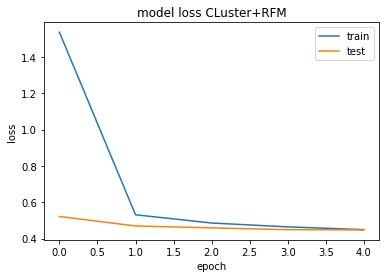

In [12]:
plt.plot(history_rfm.history["loss"])
plt.plot(history_rfm.history["val_loss"])
plt.title("model loss CLuster+RFM")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [13]:
test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
test['ProductId'].values


In [15]:
product_db = np.array(list(set(df_client_product['ProductId'])))

In [16]:
# Creating dataset for making recommendations for the first user
# With RFM

product_db = np.array(list(set(df_client_product['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1].values
user_t = np.array([user for i in range(len(product_db))])

predictions = model_rfm.predict([user_t, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [17]:
predictions

array([4.757499 , 3.558114 , 3.9175649, ..., 4.7687674, 4.284773 ,
       4.537291 ], dtype=float32)

In [18]:
max(predictions)

6.5145006